# Fase 1.0: Evaluar una ResBaGAN para clasificación de imágenes hiperespectrales

In [1]:
# Imports

import math,random,struct,os,time,sys
import numpy as np
import torch
import torch.nn as nn
import torch.onnx
from torchvision import models
from torch.utils.data import Dataset,DataLoader
from sklearn import preprocessing
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import time

# Funciones y parámetros de la ResBaGAN
import sys
sys.path.append('../src/')

import resbagan_networks
import resbagan_datasets
from cnn21_pix import read_pgm, save_pgm

## 1. Uso del flujo general para la ResBaGAN

### 1.1. Obtención del discriminador

In [2]:
# Definir parámetros

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'
MODEL="../results/models/model_ResBaGAN.pt"

# Queremos usar todos los datos para la inferencia
SAMPLES=[0.0,0.0]

In [3]:
# Carga de datos para la inferencia en el discriminador

dataset = resbagan_datasets.HyperDataset(
    "oitaven_river", segmented=False, patch_size=32, ratios=(SAMPLES[0], SAMPLES[1]))

# Almacenamos las dimensiones en variables
H = dataset.height
V = dataset.width

samples = dataset.ordered_test_set['samples']

# Obtenemos el array de gt
truth = dataset.gt.flatten()
# Obtenemos un array de indices para test
test = dataset.test_index_list

# Obtenemos el numero de clases y el numero de clases no vacias para test
nclases = dataset.classes_count
nclases_no_vacias = 0
for i in range(nclases):
    clase_actual = i + 1
    if any(truth[idx] == clase_actual for idx in test):
        nclases_no_vacias += 1

print(dataset)

# The custom HyperDataset object contains all the train, validation and test data
#   --> But it will wrapped into a PyTorch data feeder for convenience
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
)

[*] Loading dataset oitaven_river from disk
	oitaven_river dataset is in RAW format
[*] Recording available classes
[*] Starting preprocessing
[*] Scaling dataset to [-1, 1]
[*] Splitting dataset into train, validation, and test sets: ratios (0.0, 0.0)
[*] Total samples: 6067179
	[*] Recording samples for class Water (309248 items)
	[*] Recording samples for class Bare soil (113324 items)
	[*] Recording samples for class Rock (79152 items)
	[*] Recording samples for class Asphalt (43861 items)
	[*] Recording samples for class Concrete (128022 items)
	[*] Recording samples for class Tiles (78785 items)
	[*] Recording samples for class Meadows (2428482 items)
	[*] Recording samples for class Native trees (1829360 items)
	[*] Recording samples for class Pines (193884 items)
	[*] Recording samples for class Eucalyptus (863061 items)

[*] HyperDataset summary:
	Name: oitaven_river
	Shape: (height) 6689, (width) 6722, (bands) 5
	Classes: ['Water', 'Bare soil', 'Rock', 'Asphalt', 'Concrete', 

In [4]:
# Cargar la ResBaGAN

cuda=True if torch.cuda.is_available() else False
device=torch.device('cuda' if cuda else 'cpu')
device='cpu'

if torch.backends.cudnn.is_available():
    print('* Activando CUDNN')
    torch.backends.cudnn.enabled=True
    torch.backends.cudnn.beBhmark=True

hyperparams = {
    "latent_size":   128,
    "activation":    "lrelu",
    "p_dropout":     0.05,
    "weight_init":   "xavier",
    "learning_rate": 0.001,
    "epochs":        100,
    "batch_size":    100,
    "num_workers":   4,
    "device":        "cpu",
}

network = resbagan_networks.ResBaGAN(dataset=dataset, device=hyperparams["device"], hyperparams=hyperparams)
network.load_state_dict(torch.load(MODEL, map_location=hyperparams["device"]))

/tmp/ipykernel_5562/2644238578.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network.load_state_dict(torch.load(MODEL, map_location=hyperparams["device"]))


<All keys matched successfully>

In [5]:
# Separar el discriminador de la ResBaGAN y guardarlo

network.discriminator.eval()
discriminator = network.discriminator

# Guarda solo el discriminador
torch.save(discriminator.state_dict(), "../results/models/model_ResBaGAN_discriminator.pt")

### 1.2. Uso del discriminador

In [5]:
# Cargar el discriminador

model = resbagan_networks.ResBaGAN_Discriminator(dataset=dataset, device=hyperparams["device"], hyperparams=hyperparams)

# Cargar los pesos guardados
model.load_state_dict(torch.load("../results/models/model_ResBaGAN_discriminator.pt"))

/tmp/ipykernel_5562/3284926269.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../results/models/model_ResBaGAN_discriminator.pt"))


<All keys matched successfully>

In [ ]:
# Carga de datos e inferencia

# Medir el tiempo de ejecución
start_time = time.time()

# Definir parámetros

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'
MODEL="../results/models/model_ResBaGAN.pt"

# Queremos usar todos los datos para la inferencia
SAMPLES=[0.0,0.0]

# Carga de datos para la inferencia en el discriminador

dataset = resbagan_datasets.HyperDataset(
    "oitaven_river", segmented=False, patch_size=32, ratios=(SAMPLES[0], SAMPLES[1]))

# Almacenamos las dimensiones en variables
H = dataset.height
V = dataset.width

samples = dataset.ordered_test_set['samples']

# Obtenemos el array de gt
truth = dataset.gt.flatten()
# Obtenemos un array de indices para test
test = dataset.test_index_list

# Obtenemos el numero de clases y el numero de clases no vacias para test
nclases = dataset.classes_count
nclases_no_vacias = 0
for i in range(nclases):
    clase_actual = i + 1
    if any(truth[idx] == clase_actual for idx in test):
        nclases_no_vacias += 1

print(dataset)

# The custom HyperDataset object contains all the train, validation and test data
#   --> But it will wrapped into a PyTorch data feeder for convenience
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
)

# Inferencia
output=np.zeros(H*V, dtype=np.uint8)

# Modo evaluación
model.eval()
dataset.to_test()

# Realizar la predicción
with torch.no_grad():
    total=0
    for batch_id, (inputs, labels, targets_pixel_level) in enumerate(data_loader):
        inputs=inputs.to(device)
        outputs_discriminator, _ = model(inputs)
        outputs_discriminator[:, dataset.classes_count] = -math.inf # Se deshabilita la clase fake para test
        _, outputs_discriminator = torch.max(outputs_discriminator, dim=1)
        predicted_cpu=outputs_discriminator.cpu()
        for i in range(len(predicted_cpu)):
            output[test[total+i]]=np.uint8(predicted_cpu[i]+1)
        total+=labels.size(0)
        if(total%100000==0): print('  Test:',total,'/', len(dataset))

end_time = time.time()

print("Prediction time: {:.4f} seconds".format(end_time - start_time))

[*] Loading dataset oitaven_river from disk
	oitaven_river dataset is in RAW format
[*] Recording available classes
[*] Starting preprocessing
[*] Scaling dataset to [-1, 1]
[*] Splitting dataset into train, validation, and test sets: ratios (0.0, 0.0)
[*] Total samples: 6067179
	[*] Recording samples for class Water (309248 items)
	[*] Recording samples for class Bare soil (113324 items)
	[*] Recording samples for class Rock (79152 items)
	[*] Recording samples for class Asphalt (43861 items)
	[*] Recording samples for class Concrete (128022 items)
	[*] Recording samples for class Tiles (78785 items)
	[*] Recording samples for class Meadows (2428482 items)
	[*] Recording samples for class Native trees (1829360 items)
	[*] Recording samples for class Pines (193884 items)
	[*] Recording samples for class Eucalyptus (863061 items)

[*] HyperDataset summary:
	Name: oitaven_river
	Shape: (height) 6689, (width) 6722, (bands) 5
	Classes: ['Water', 'Bare soil', 'Rock', 'Asphalt', 'Concrete', 

In [7]:
# Guardar el output

np.save('../results/predictions/predictions_ResBaGAN_discriminator.npy', output)

In [10]:
# Cargar el output

output = np.load('../results/predictions/predictions_ResBaGAN_discriminator.npy')

In [8]:
# Evaluar el desempeño del modelo

# Precisiones a nivel de clase
correct=0; total=0; AA=0; OA=0
class_correct=[0]*(nclases+1)
class_total=[0]*(nclases+1)
class_aa=[0]*(nclases+1)

for i in test:
    if(output[i]==0 or truth[i]==0): continue
    total+=1; class_total[truth[i]]+=1
    if(output[i]==truth[i]):
          correct+=1
          class_correct[truth[i]]+=1
for i in range(1,nclases+1):
    if(class_total[i]!=0): class_aa[i]=100*class_correct[i]/class_total[i]
    else: class_aa[i]=0
    AA+=class_aa[i]
OA=100*correct/total; AA=AA/nclases_no_vacias

for i in range(1,nclases+1): print('  Class %02d: %02.02f'%(i,class_aa[i]))
print('* Accuracy (pixels) OA=%02.02f, AA=%02.02f'%(OA,AA))
print('  total:',total,'correct:',correct)

  Class 01: 99.01
  Class 02: 91.91
  Class 03: 87.23
  Class 04: 97.64
  Class 05: 91.87
  Class 06: 99.20
  Class 07: 96.95
  Class 08: 98.35
  Class 09: 99.81
  Class 10: 96.23
* Accuracy (pixels) OA=97.17, AA=95.82
  total: 6067179 correct: 5895523


In [9]:
# Guardar la salida

save_pgm(output,V,H,nclases,'../results/predictions/predictions_ResBaGAN_discriminator.pgm')

* Saved file: ../results/predictions/predictions_ResBaGAN_discriminator.pgm


* Read GT: ../results/predictions/predictions_ResBaGAN_discriminator.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


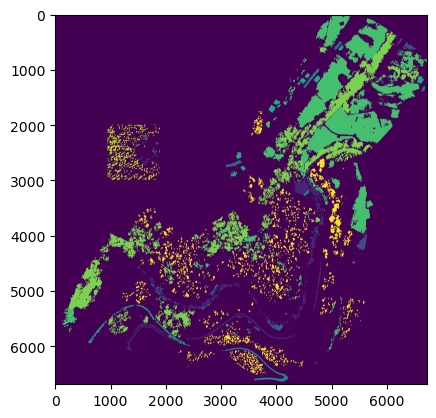

In [10]:
# Mostrar la salida

OUTPUT='../results/predictions/predictions_ResBaGAN_discriminator.pgm'

(imagen_output, H, V) = read_pgm(OUTPUT)

# Convertir la lista a array y redimensionar
imagen_output = np.array(imagen_output, dtype=np.uint8).reshape(V, H)

# Mostrar la imagen
plt.imshow(imagen_output)
plt.show()